
-<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [1]:
import os
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
from PIL import Image
import torchvision.transforms as tt
import torchvision.utils as vutils
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.models import resnet18
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import sys
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
import gc
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [4]:
SEED = 0
TRAIN_ZIP_PATH = 'C:\\Users\\sasha\\PycharmProjects\\gazprom\\faces_dataset_small.zip'
TRAIN_PATH = 'C:\\Users\\sasha\\PycharmProjects\\gazprom\\faces_dataset_small'

IMAGES_FOLDER = 'C:\\Users\\sasha\\PycharmProjects\\gazprom\\faces_dataset_small'
FOLDER_TO_REMOVE_IN_ZIP = '\\content\\faces_dataset_small\\faces_dataset_small\\04000'
SLASH = '\\'

RESIZING_SIZE = 128
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 16

LATENT_SIZE = 128
N_OF_FEATURE_MAPS_IN_DISC = 64
N_OF_FEATURE_MAPS_IN_GEN = 64
OPTIMIZER_LR = 0.0001
OPTIMIZER_BETAS = (0.5, 0.999)
EPOCHS = 100

In [5]:
set_seed(SEED)

In [6]:
# zip_file = zipfile.ZipFile(TRAIN_ZIP_PATH, 'r')
# zip_file.extractall(TRAIN_PATH)
# zip_file.close()

In [7]:
# %rm -rf {FOLDER_TO_REMOVE_IN_ZIP}

In [8]:
# !rm /content/faces_dataset_small/faces_dataset_small/.DS_Store

In [9]:
class FlickrFacesDataset(Dataset):
    def __init__(self, images_path, transform=None):
        self.images_path = images_path
        if transform is not None:
            self.transform = transform
        else:
            self.transform = None
    
    def __getitem__(self, idx):
        selected_image = Image.open(self.images_path[idx])
        if self.transform is not None:
            selected_image = self.transform(selected_image)
        return selected_image

    def __len__(self):
        return len(self.images_path)

In [94]:
def get_dataloader(images_path, image_size, batch_size, device):
    """
    Builds dataloader for training data.
    Use tt.Compose and tt.Resize for transformations
    :param image_size: height and wdith of the image
    :param batch_size: batch_size of the dataloader
    :returns: DataLoader object 
    """
    # TODO: resize images, convert them to tensors and build dataloader
    transform = tt.Compose(
    [
     tt.Resize((image_size, image_size)),
     tt.ToTensor(),
     ])
    flickr_dataset = FlickrFacesDataset(images_path, transform)

    dataloader = DataLoader(
        flickr_dataset, 
        batch_size=batch_size, 
        shuffle=True,
        collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)),
        drop_last=True,
        )
    
    return dataloader

In [11]:
images = [IMAGES_FOLDER + SLASH + name for name in os.listdir(IMAGES_FOLDER)]

In [95]:
#TODO: build dataloader and transfer it to device
dataloader = get_dataloader(images, RESIZING_SIZE, BATCH_SIZE, DEVICE)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [13]:
class Discriminator(nn.Module):
    def __init__(self, number_of_feature_maps):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=number_of_feature_maps,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
                ),
            nn.LeakyReLU(0.2, inplace=True),
            # size of batch x nfm x 64 x 64
            nn.Conv2d(
                in_channels=number_of_feature_maps, 
                out_channels=number_of_feature_maps, 
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False
                ),
            nn.LeakyReLU(0.2, inplace=True),
            # size of batch x nfm x 32 x 32
            nn.Conv2d(
                in_channels=number_of_feature_maps, 
                out_channels=number_of_feature_maps * 2, 
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False
                ),
            nn.BatchNorm2d(number_of_feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # size of batch x (nfm*2) x 16 x 16
            nn.Conv2d(
                in_channels=number_of_feature_maps * 2, 
                out_channels=number_of_feature_maps * 4, 
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False
                ),
            nn.BatchNorm2d(number_of_feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # size of batch x (nfm*4) x 8 x 8
            nn.Conv2d(
                in_channels=number_of_feature_maps * 4, 
                out_channels=number_of_feature_maps * 8, 
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False
                ),
            nn.BatchNorm2d(number_of_feature_maps * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # size of batch x (nfm*8) x 4 x 4
            nn.Conv2d(
                in_channels=number_of_feature_maps * 8, 
                out_channels=1, 
                kernel_size=4, 
                stride=1, 
                padding=0, 
                bias=False
                ),
            nn.Flatten(),
            # size of batch x 1
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.main(x)
        return x

In [14]:
class Generator(nn.Module):
    def __init__(self, latent_size, n_of_feature_maps_in_gen):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=latent_size, 
                out_channels=n_of_feature_maps_in_gen * 8, 
                kernel_size=4, 
                stride=1, 
                padding=0, 
                bias=False
                ),
            nn.BatchNorm2d(n_of_feature_maps_in_gen * 8),
            nn.ReLU(True),
            # size of batch x (ngf*8) x 4 x 4
            nn.ConvTranspose2d(
                in_channels=n_of_feature_maps_in_gen * 8, 
                out_channels=n_of_feature_maps_in_gen * 4, 
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False
                ),
            nn.BatchNorm2d(n_of_feature_maps_in_gen * 4),
            nn.ReLU(True),
            # size of batch x (ngf*4) x 8 x 8
            nn.ConvTranspose2d(
                in_channels=n_of_feature_maps_in_gen * 4, 
                out_channels=n_of_feature_maps_in_gen * 2, 
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False
                ),
            nn.BatchNorm2d(n_of_feature_maps_in_gen * 2),
            nn.ReLU(True),
            # size of batch x (ngf*2) x 16 x 16
            nn.ConvTranspose2d( 
                in_channels=n_of_feature_maps_in_gen * 2, 
                out_channels=n_of_feature_maps_in_gen, 
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False
                ),
            nn.BatchNorm2d(n_of_feature_maps_in_gen),
            nn.ReLU(True),
            # size of batch x (ngf) x 32 x 32
            nn.ConvTranspose2d( 
                in_channels=n_of_feature_maps_in_gen, 
                out_channels=n_of_feature_maps_in_gen, 
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False
                ),
            nn.BatchNorm2d(n_of_feature_maps_in_gen),
            nn.ReLU(True),
            # size of batch x (ngf) x 64 x 64
            nn.ConvTranspose2d( 
                in_channels=n_of_feature_maps_in_gen, 
                out_channels=3, 
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False
                ),
            nn.Tanh()
            # size of batch x 3 x 128 x 128
        )
    def forward(self, x):
        x = self.main(x)
        return x

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [15]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [16]:
discriminator = Discriminator(N_OF_FEATURE_MAPS_IN_GEN)
discriminator.apply(weights_init)
generator = Generator(LATENT_SIZE, N_OF_FEATURE_MAPS_IN_GEN)
generator.apply(weights_init)

criterion = nn.BCELoss()

optimizerD = torch.optim.Adam(
    discriminator.parameters(), lr=OPTIMIZER_LR, betas=OPTIMIZER_BETAS
    )
optimizerG = torch.optim.Adam(
    generator.parameters(), lr=OPTIMIZER_LR, betas=OPTIMIZER_BETAS
    )

In [17]:
def fit(discriminator, 
        generator, 
        criterion, 
        optimizer_discriminator, 
        optimizer_generator, 
        epochs
        ):
    
    # TODO: build optimizers and train your GAN
    
    discriminator = discriminator.to(DEVICE)
    generator = generator.to(DEVICE)
    
    losses_discriminator = []
    losses_generator = []

    for e in range(1, epochs + 1):
        
        length_of_training = len(dataloader)

        with tqdm(total=length_of_training, file=sys.stdout) as prbar:
            
            for index, X_batch in enumerate(dataloader):         
                
                # 1. DISCRIMINATOR TRAINING

                # discriminator loss calculation on real images
                discriminator.zero_grad()
                true_labels = torch.full((BATCH_SIZE, 1), 1.0)
                true_labels = true_labels.to(DEVICE)
                X_batch = torch.stack(X_batch).to(DEVICE)

                pred_labels = discriminator(X_batch)

                true_discriminator_loss = criterion(
                    pred_labels, true_labels
                    )
                true_discriminator_loss.backward()

                # discriminator loss calculation on fake images
                random_generated_noise = torch.randn(
                    (BATCH_SIZE, LATENT_SIZE, 1, 1)
                    )
                random_generated_noise = random_generated_noise.to(DEVICE)
                generated_images = generator(random_generated_noise)
                fake_labels = torch.full((BATCH_SIZE, 1), 0.0).to(DEVICE)

                pred_labels = discriminator(generated_images.detach())
                fake_discriminator_loss = criterion(
                    pred_labels, fake_labels
                )
                fake_discriminator_loss.backward()

                discriminator_loss = true_discriminator_loss + fake_discriminator_loss
                optimizer_discriminator.step()
                
                # 2. GENERATOR TRAINING

                generator.zero_grad()

                # swapping real labels with fake in order to fool the discriminator
                fake_labels = torch.full((BATCH_SIZE, 1), 1.0).to(DEVICE)
                
                # using previously generated images for classification
                pred_labels = discriminator(generated_images)
                
                generator_loss = criterion(
                    pred_labels, fake_labels
                )
                generator_loss.backward()
                optimizer_generator.step()
                
                # calculation of losses for statistics
                train_loss_discriminator = discriminator_loss.item()
                train_loss_generator = generator_loss.item()
                prbar.set_description(
                    f'Epoch {e} \n'
                    f'discriminator loss: {round(train_loss_discriminator, 4)} \n'
                    f'generator loss: {round(train_loss_generator, 4)}'
                )
                prbar.update(1)
                losses_generator.append(train_loss_generator)
                losses_discriminator.append(train_loss_discriminator)

        # Generate images to show as example
        random_generated_noise = torch.randn(
                    (BATCH_SIZE, LATENT_SIZE, 1, 1)
                    ).to(DEVICE)
        generated_imgs_examples = generator(random_generated_noise)
        ncols = BATCH_SIZE // 2
        nrows = BATCH_SIZE // ncols
        fig, axes = plt.subplots(nrows, ncols, figsize=(20, 5))
        index = 0
        for row in range(nrows):
            for col in range(ncols):
                image = generated_imgs_examples[index]
                image = image.detach().cpu().numpy()
                image = np.transpose(image, [1, 2, 0])
                axes[row, col].imshow(image)
                index += 1
                axes[row, col].grid(False)
                axes[row, col].axis(False)
        plt.show()
    return losses_discriminator, losses_generator

In [ ]:
losses_discriminator, losses_generator = fit(
    discriminator, generator, criterion, optimizerD, optimizerG, EPOCHS
    )

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

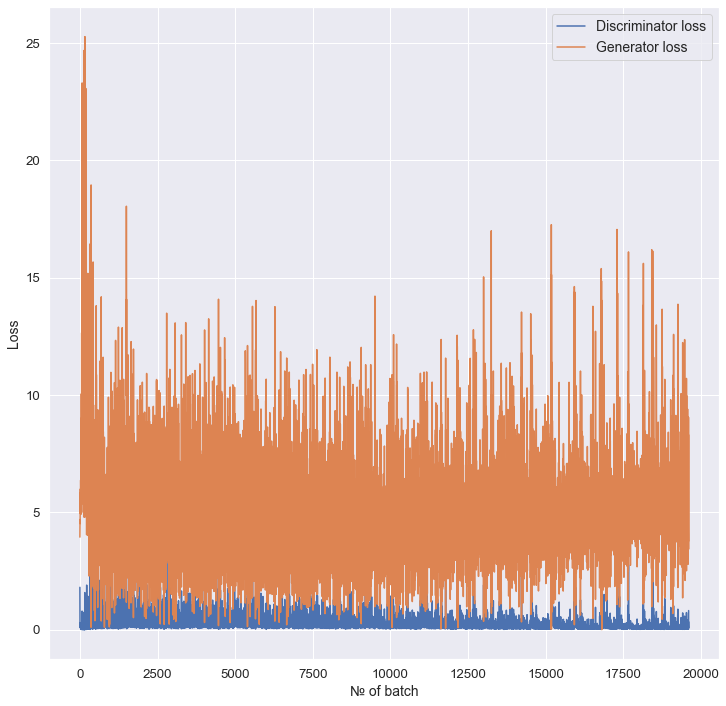

In [45]:
x = np.arange(1, len(losses_discriminator) + 1)
plt.figure(figsize=(12, 12))
plt.plot(x, losses_discriminator, label='Discriminator loss')
plt.plot(x, losses_generator, label='Generator loss')
plt.ylabel('Loss', fontsize=14)
plt.xlabel('№ of batch', fontsize=14)
plt.legend(fontsize=14)
plt.show()

Видно, что график хаотичен - как и должно быть, так как генератор и дискриминатор находятся в поисках точки эквилибриума. Дискриминатор на рандоме бы указывал, фейковое ли изображение, так и генератор бы создавал такие похожие на исходные изображения, что дискриминатору было бы невозможно распознать фейк.

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [20]:
n_images = 4

fixed_latent = torch.randn(n_images, LATENT_SIZE, 1, 1, device=DEVICE)
fake_images = generator(fixed_latent)

In [37]:
def show_images(generated_imgs):
    # TODO: show generated images
    generated_imgs = generated_imgs.detach().cpu().numpy()
    generated_imgs = np.transpose(generated_imgs, (0, 3, 2, 1))
    n_of_imgs = len(generated_imgs)
    fig, axes = plt.subplots(nrows=1, ncols=n_of_imgs, figsize=(20, 20))
    for img in range(n_of_imgs):
        generated_img = generated_imgs[img]
        generated_img = generated_img/np.amax(generated_img)
        axes[img].imshow(generated_img)
        axes[img].axis(False)
        axes[img].grid(False)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


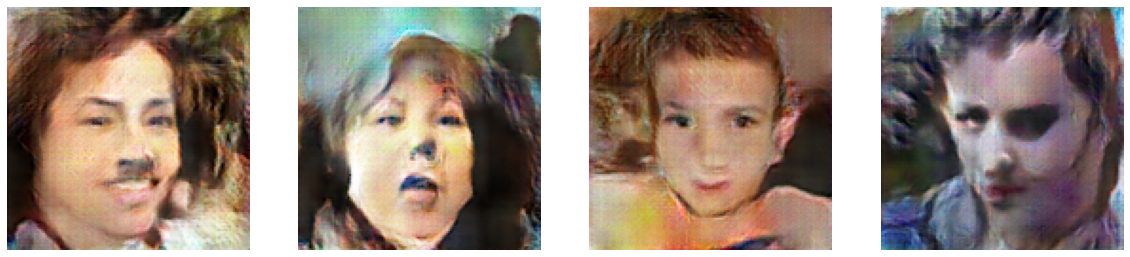

In [38]:
show_images(fake_images)

Как вам качество получившихся изображений?

Можно сказать, что генератор действительно производит изображения, похожие на лица людей. Но, в целом, они далеки от хорошего результата.

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [345]:
fake_imgs = []
for _ in tqdm(range(len(iter(dataloader)))):
    latent_vector_of_imgs = torch.randn(
        BATCH_SIZE, LATENT_SIZE, 1, 1, device=DEVICE
    )
    generator.eval()
    with torch.no_grad():
        fake_imgs_batch = generator(latent_vector_of_imgs)
        fake_imgs.append(fake_imgs_batch)
    latent_vector_of_imgs = latent_vector_of_imgs.cpu()
    del latent_vector_of_imgs

  0%|          | 0/196 [00:00<?, ?it/s]

In [346]:
real_imgs = []
for X_batch in tqdm(dataloader):
    real_imgs.append(X_batch)

  0%|          | 0/196 [00:00<?, ?it/s]

In [225]:
fake_imgs = torch.stack(fake_imgs)
real_imgs = torch.stack([torch.stack(x) for x in real_imgs])
fake_imgs = fake_imgs.reshape((-1, 3, RESIZING_SIZE, RESIZING_SIZE))
real_imgs = real_imgs.reshape((-1, 3, RESIZING_SIZE, RESIZING_SIZE))

fake_imgs, real_imgs = fake_imgs.cpu(), real_imgs.cpu()
gc.collect()
torch.cuda.empty_cache()

fake_labels = torch.full([len(fake_imgs)], 0)
real_labels = torch.full([len(real_imgs)], 1)
labels = torch.cat((fake_labels, real_labels), dim=0)

images_to_test = torch.cat((fake_imgs, real_imgs), dim=0)

shuffled_idxs = torch.randperm(len(images_to_test))
images_to_test = images_to_test[shuffled_idxs]
labels = labels[shuffled_idxs]

In [227]:
images_to_test = images_to_test.reshape((-1, 3*RESIZING_SIZE*RESIZING_SIZE))

In [228]:
loo = LeaveOneOut()
accuracy_scores = []
for train_index, test_index in tqdm(loo.split(images_to_test)):
    train_imgs, test_img = images_to_test[train_index], images_to_test[test_index]
    train_labels, test_label = labels[train_index], labels[test_index]
    classifier = KNeighborsClassifier(n_neighbors=1)
    classifier.fit(train_imgs, train_labels)
    pred_label = classifier.predict(test_img)
    accuracy = accuracy_score(test_label, pred_label)
    accuracy_scores.append(accuracy)

0it [00:00, ?it/s]

In [233]:
print(f'Точность равна {round(np.mean(accuracy_scores), 2)}')

Точность равна 0.96


Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

Мы получили плохую оценку качества _GAN_. По идее, наилучшим вариантом было бы получить точность в $0.5$ $-$ это бы означало, что разница между фейковыми и оригинальными изображениями мала, классификатор попросту не может уловить различий и потому "гадает" ответ.

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [351]:
sne = TSNE(n_components=2, verbose=1)

In [352]:
real_imgs_points = sne.fit_transform(real_imgs)
fake_imgs_points = sne.fit_transform(fake_imgs)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3136 samples in 0.107s...
[t-SNE] Computed neighbors for 3136 samples in 5.278s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3136
[t-SNE] Computed conditional probabilities for sample 2000 / 3136
[t-SNE] Computed conditional probabilities for sample 3000 / 3136
[t-SNE] Computed conditional probabilities for sample 3136 / 3136
[t-SNE] Mean sigma: 14.318341
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.909355
[t-SNE] KL divergence after 1000 iterations: 2.463655
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3136 samples in 0.111s...
[t-SNE] Computed neighbors for 3136 samples in 5.172s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3136
[t-SNE] Computed conditional probabilities for sample 2000 / 3136
[t-SNE] Computed conditional probabilities for sample 3000 / 3136
[t-SNE] Computed conditional probabilities for sample 3136 / 3136
[t-SNE] Mean sigma: 13.28846

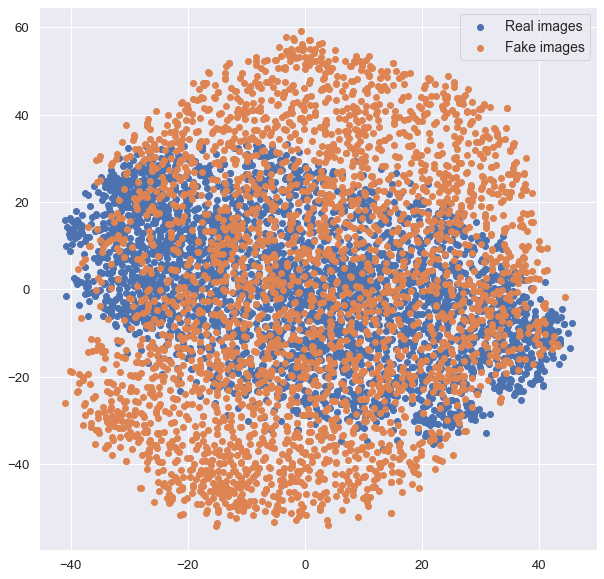

In [364]:
plt.figure(figsize=(10, 10))
plt.scatter(real_imgs_points[:, 0], real_imgs_points[:, 1], label='Real images')
plt.scatter(fake_imgs_points[:, 0], fake_imgs_points[:, 1], label='Fake images')
plt.legend(fontsize=14)
plt.show()

Прокомментируйте получившийся результат:

Получается, часть фейковых изображений действительно похожа на реальные - точки находятся близко друг к другу. В то же время, множество точек фейковых изображений расположено за пределами распределения точек реальных изображений, то есть, можно сказать, что генератор пока не смог добиться хорошего качества картинок.